In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import networkx as nx
import os, sys
from itertools import product
import math

In [2]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(20,8)})

In [3]:
#global function that calculates the weight of the edge, args: the 2 nodes (agent class objects)
def Edge_Weight(node1,node2, b, a):
        try:
             weight = 1+math.exp(a*((node1.m-node2.m)-b))
        except OverflowError:
             weight = float('inf')
        return 1/weight
                

In [4]:
#0<gamma_L<gamma_H<1
gamma_L = 0.3
gamma_H = 0.45
fixed_cost = 0.45
alpha = np.random.normal(loc = 1.08, scale = 0.074, size = 100) 
money = np.random.uniform(low = 0.1, high = 10, size = 100)

#alpha.sort()
#money.sort()

In [18]:
class MoneyAgent(Agent):
    
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.m = money[unique_id]#initialising the wealth
        self.lamda = round(random.uniform(0.1,1),1) #saving propensity
        self.micro = 0
        while (self.lamda == 1):
            self.lamda = round(random.uniform(0.1,1),1)
        self.alpha = alpha[unique_id]#human capital 
        self.model.agents.append(self)
        
    def neighbors(self):
        neighbors_nodes = list(nx.all_neighbors(self.model.G,self.unique_id))
        neighbors = []
        for node in neighbors_nodes:
            for agent in self.model.agents:
                if(agent.unique_id == node):
                    neighbors.append(agent)
        return neighbors
    
    
    def income_generation(self): #function that decides income based on the type of technology
        #print("income")
        for agent in self.model.agents:
            H = agent.alpha*math.pow(agent.m,gamma_H) - fixed_cost
            L = agent.alpha*math.pow(agent.m,gamma_L)
            if(H>=L): #
                agent.m = H
            else:
                agent.m = L
            self.micro = L
            
    def give_money(self): #function used to trade/communicate
        #print("trade")
        b = self.model.b
        a = self.model.a
        neighbors = self.neighbors()
        epsilon = random.random()
        if len(neighbors) > 1 :
            other = self.random.choice(neighbors)
            while(other.unique_id == self.unique_id):
                other = self.random.choice(neighbors)  
            w = self.model.G[self.unique_id][other.unique_id]['weight'] 
            #print(w)
            if(w >= random.random()): 
                xi = self.m
                xj = other.m
                delta_m = (1-self.lamda)*(xi - epsilon*(xi + xj))
                xi_new = xi - delta_m
                xj_new = xj + delta_m
                other.m = xj_new
                self.m = xi_new
                for neighbor in neighbors:
                    self.model.G[self.unique_id][neighbor.unique_id]['weight'] = Edge_Weight(self,neighbor,b, a)
                other_neighbors = other.neighbors()
                for neighbor in other_neighbors:
                    if(neighbor.unique_id != other.unique_id):
                        #print("Other: {}  Neighbor: {}".format(other.unique_id,neighbor.unique_id))
                        self.model.G[other.unique_id][neighbor.unique_id]['weight'] = Edge_Weight(other,neighbor,b, a)
                
    def Local_Attachment(self): #link addition happening at every time step
        #print("attach")
        b =  self.model.b
        a = self.model.a
        node1 = random.choice(self.model.nodes)
        node2 = random.choice(self.model.nodes)
        while(self.model.G.has_edge(node1,node2)==True):
            node2 = random.choice(self.model.nodes)
            node1 = random.choice(self.model.nodes)
        for agent in self.model.agents:
            if(agent.unique_id == node1):
                node1_a = agent
            if(agent.unique_id == node2):
                node2_a = agent
        self.model.G.add_edge(node1,node2,weight = Edge_Weight(node1_a,node2_a, b, a))
        
    
    def Link_Deletion(self):
        #print("delete")
        node1 = random.choice(self.model.nodes)
        node2 = random.choice(self.model.nodes)
        while(self.model.G.has_edge(node1,node2)==False):
            node1 = random.choice(self.model.nodes)
            node2 = random.choice(self.model.nodes)
        self.model.G.remove_edge(node1,node2)
        
                 
    def step(self):
        self.income_generation()
        if self.m > 0:
            self.give_money()
        self.Local_Attachment()
        self.Link_Deletion()

In [22]:
class BoltzmannWealthModelNetwork(Model):
    """A model with some number of agents."""

    def __init__(self,b, a,N=500,): #N- number of agents

        self.N = N
        self.b =b
        self.a = a
        self.agents = []
        self.mean = 0
        self.G = nx.barabasi_albert_graph(n=N, m = 1)
        nx.set_edge_attributes(self.G, 1, 'weight') #setting all initial edges with a weight of 1
        #print(nx.get_edge_attributes(self.G,'weight'))
        #nx.draw(self.G)
        self.nodes = np.linspace(0,N-1,N, dtype = 'int') #to keep track of the N nodes   
        
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(model_reporters = {'mean' : 'mean','beta': 'b', 'a': 'a'},agent_reporters={"mi":'m','lamda':'lamda','alpha':'alpha','threshold':'micro' })       
        for i, node in enumerate(self.G.nodes()):
            agent_i = MoneyAgent(i, self)
            self.schedule.add(agent_i)
           
        self.running = True
        self.datacollector.collect(self)
        
    def Global_Attachment(self):
        #print("Global Attachment no: {}".format(self.count))
        node1 = random.choice(self.nodes)
        node2 = random.choice(self.nodes)
        while(self.G.has_edge(node1,node2)==True):
            node2 = random.choice(self.nodes)
            node1 = random.choice(self.nodes)
        #adding the edge node1-node2
        for agent in self.agents:
            if(agent.unique_id == node1):
                node1_a = agent
            if(agent.unique_id == node2):
                node2_a = agent
        self.G.add_edge(node1,node2,weight = Edge_Weight(node1_a,node2_a, self.b, self.a))
    
    def step(self):
        self.schedule.step()
        # collect data
        self.datacollector.collect(self)

    def run_model(self, n):
        for i in tqdm(range(n)):
            self.step()
            self.Global_Attachment()
            agent_data = self.datacollector.get_agent_vars_dataframe()
            self.mean = agent_data['mi'].mean()
            #here, find mean and variance and save it as model parameters
            

In [31]:
N = 100
steps = 500
b = 35
a = 0.69
model = BoltzmannWealthModelNetwork(b, a,N)
model.run_model(steps)
model_df = model.datacollector.get_model_vars_dataframe()
agent_df = model.datacollector.get_agent_vars_dataframe()
agent_df.reset_index(level=1, inplace = True)
#agent_df['mt'] = agent_df.mi/T
#del agents

C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [32]:
agent_df

,AgentID,mi,lamda,alpha,threshold
Step,,,,,
0,0,8.161341,0.5,1.135394,0.000000
0,1,1.066256,0.5,1.176597,0.000000
0,2,1.066256,0.4,1.098079,0.000000
0,3,1.066256,0.6,1.063050,0.000000
0,4,1.066256,0.3,1.162382,0.000000
...,...,...,...,...,...
500,95,1.132229,0.2,1.090822,1.280653
500,96,1.086177,0.7,1.059572,1.280431
500,97,1.054210,0.2,1.063112,1.281913


In [33]:
file = "AlbertBarabasi\HumanCapital_Data\Steps{}b_is_{}_FixedCost_0.45_a_{}_New".format(steps,b,a)
os.makedirs(file)

In [34]:
#saving files
model_df.loc[1:].to_csv(file + "\Model.csv")               
#agent_df['mt'] = agent_df.mi/T
agent_df.to_csv(file +"\Agent.csv")

In [35]:
data = pd.read_csv(file + "\Agent.csv")
data.tail()

,Step,AgentID,mi,lamda,alpha,threshold
50095,500,95,1.132229,0.2,1.090822,1.280653
50096,500,96,1.086177,0.7,1.059572,1.280431
50097,500,97,1.054210,0.2,1.063112,1.281913
50098,500,98,1.103517,0.4,1.071384,1.280431
50099,500,99,1.280565,0.9,1.188911,1.280431


In [28]:
data['mi'].max()

9.757865391615713

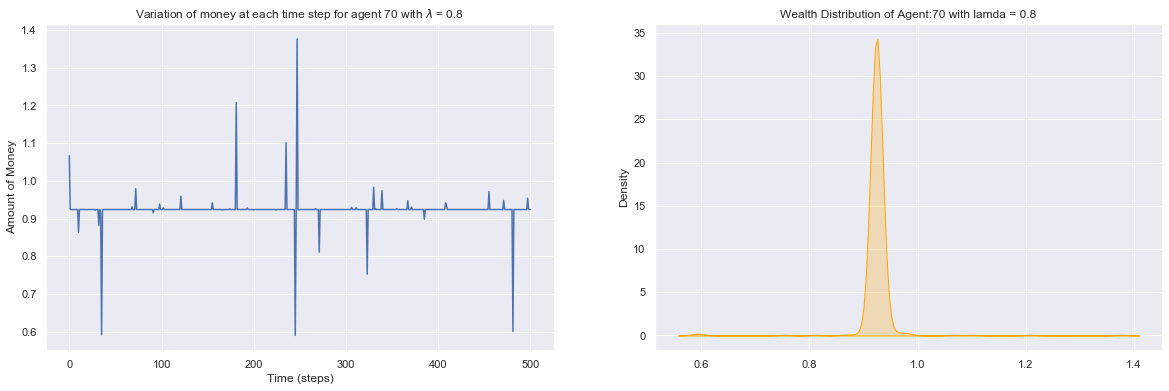

In [36]:
agent = random.randint(0,99)
time = (data.loc[data['AgentID']==agent, 'Step'].reset_index(drop = True)).to_numpy()
money = (data.loc[data['AgentID']==agent, 'mi'].reset_index(drop = True)).to_numpy()
lamda = data.loc[data['AgentID'] == agent, 'lamda'].reset_index(drop = True)[0]
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(20,6)})
fig, (ax1, ax2) = plt.subplots(nrows = 1,ncols = 2)
ax1.plot(time,money)
ax1.set_title("Variation of money at each time step for agent {} with $\lambda$ = {}".format(agent,lamda))
ax1.set_xlabel("Time (steps)")
ax1.set_ylabel("Amount of Money")
sns.kdeplot(money, fill =True, color = 'orange', ax = ax2)
ax2.set_title("Wealth Distribution of Agent:{} with lamda = {}".format(agent, lamda))
plt.savefig(file + "\WealthDist_agent{}".format(agent))

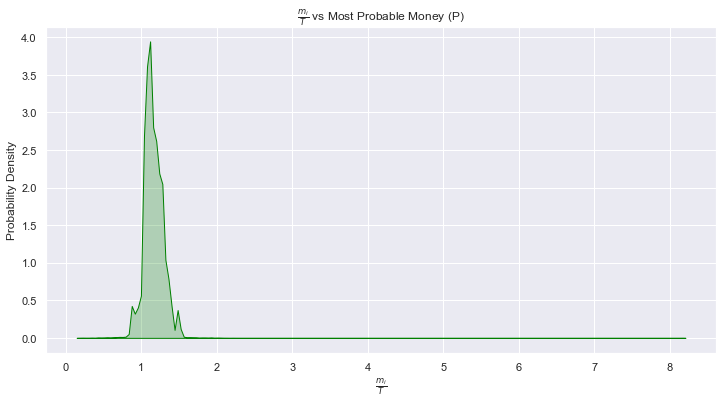

In [37]:
sns.set(rc={'figure.figsize':(12,6)})
sns.kdeplot(data.mi, fill = True, color = 'green')
plt.xlabel("$\\frac{m_i}{T}$")
plt.ylabel("Probability Density")
plt.title("$\\frac{m_i}{T}$ vs Most Probable Money (P)") 
plt.savefig(file + "\kdeplot_homophily");

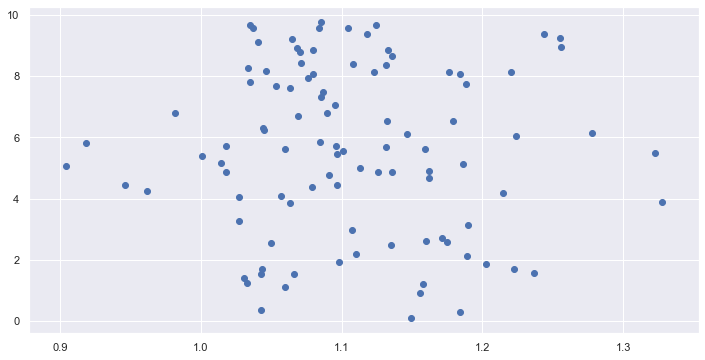

In [17]:
ability = data.loc[data['Step']==199, 'alpha'].reset_index(drop = True).to_numpy()
money = data.loc[data['Step']==0, 'mi'].reset_index(drop = True).to_numpy()
plt.scatter(ability, money)